In [1]:
# import CartPole.py from local directory
import CartPole, sf3utility
import matplotlib.collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate, scipy.stats.qmc, scipy.optimize
import random, copy, time

plt.rcParams["font.family"] = "Georgia"
#plt.rcParams['figure.figsize'] = [9.0, 7.0]
#plt.rcParams['figure.dpi'] = 400

# store results for later
cache = {}

%matplotlib notebook

<IPython.core.display.Javascript object>


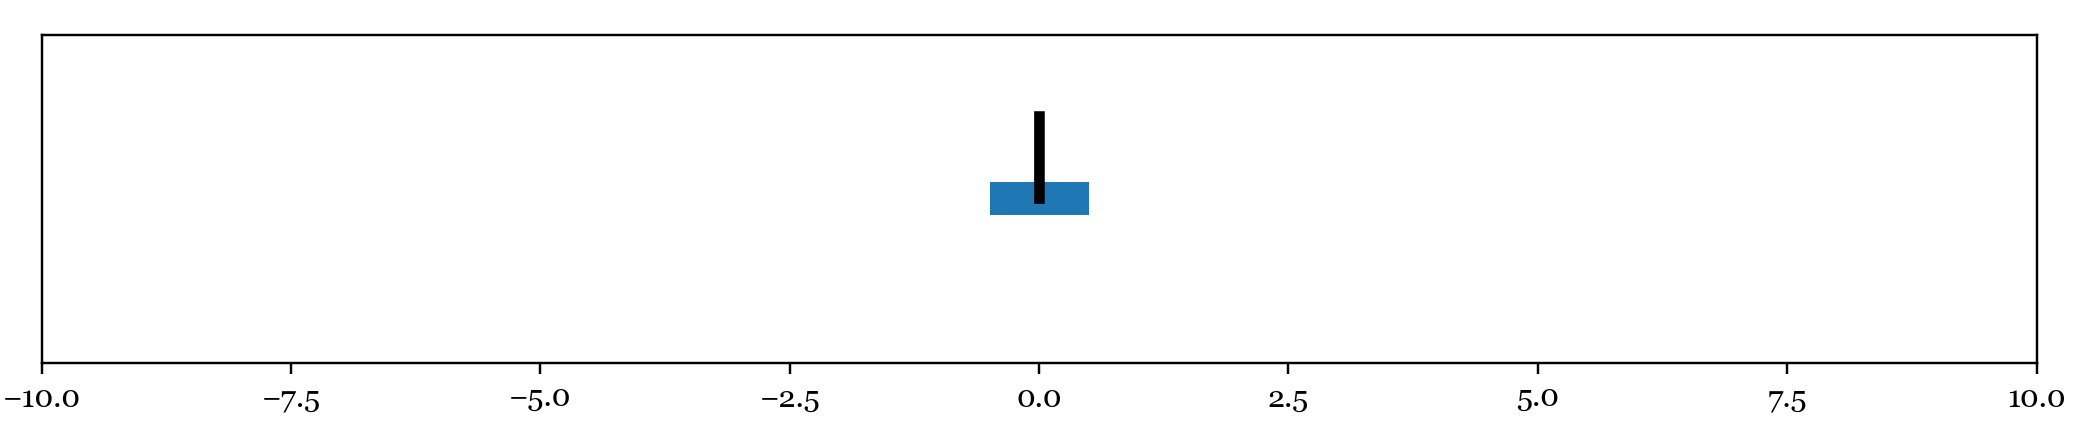

In [2]:
cart_pole = CartPole.CartPole( visual=True, save_frames=False, fig_num=58 )

state = np.array( [ 1., 0, 0, 0, 0 ] )
cart_pole.set_state( state )
cart_pole._render()

In [3]:
p = np.array([-1, -1.5, 0, -1, 0]) # steady at middle

for i in range(50):

    state[4] = p @ state
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()

forces = [5, 5, -5, -5, -5, -5, 4, 4, 4, 4, -2, -2]

for i, force in enumerate(forces):
    
    state[4] = force
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()
    
p = np.array( [0.75971638,  1.44284499, 17.05744679,  2.66183469, 0] ) # upright at middle

for i in range(50):

    state[4] = p @ state
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()

# Task 4 - Nonlinear Control

Next, I want to design a controller that works even better - one that can keep the pole upright starting from the stable equilibrium. As a first step, I manually designed such a policy as follows.
1. Use a linear policy to bring the cartpole to the stable equilibrium, at the origin.
2. Apply a certain sequence of force inputs to swing up the pole.
3. Use another linear policy to keep the pole upright.

For step 1, I used standard PD controller tuning technqiues to find a policy vector p = [ -1, -1.5, 0, -1 ]. For step 3, I used the policy vector I found in task 2.3, p = [ 0.76, 1.44, 17.06, 2.66 ]. For step two, I applied some intuition that the cart will need to swing back and forth to raise up the pole gradually over a few oscillations. I therefore started with a list of force values that alternated in sign every few time steps (frequency roughly matched to pole natural frequency), then tuned the exact values until the second linear policy could "catch" the system in its resultant state and stablise it. The list of force values I found is [ 5, 5, -5, -5, -5, -5, 4, 4, 4, 4, -2, -2 ].

I like this approach because it leverages a human intuitive understanding of the system to simplify the problem, and works with the computer to solve it in small, manageable chunks. Designing this controller took about 15 minutes and gives ideal results. The drawback is that this type of controller will probably not work well at all in the presence of noise, and is specialised to this system - the same method may not be tractable for another system/dataset.

<IPython.core.display.Javascript object>


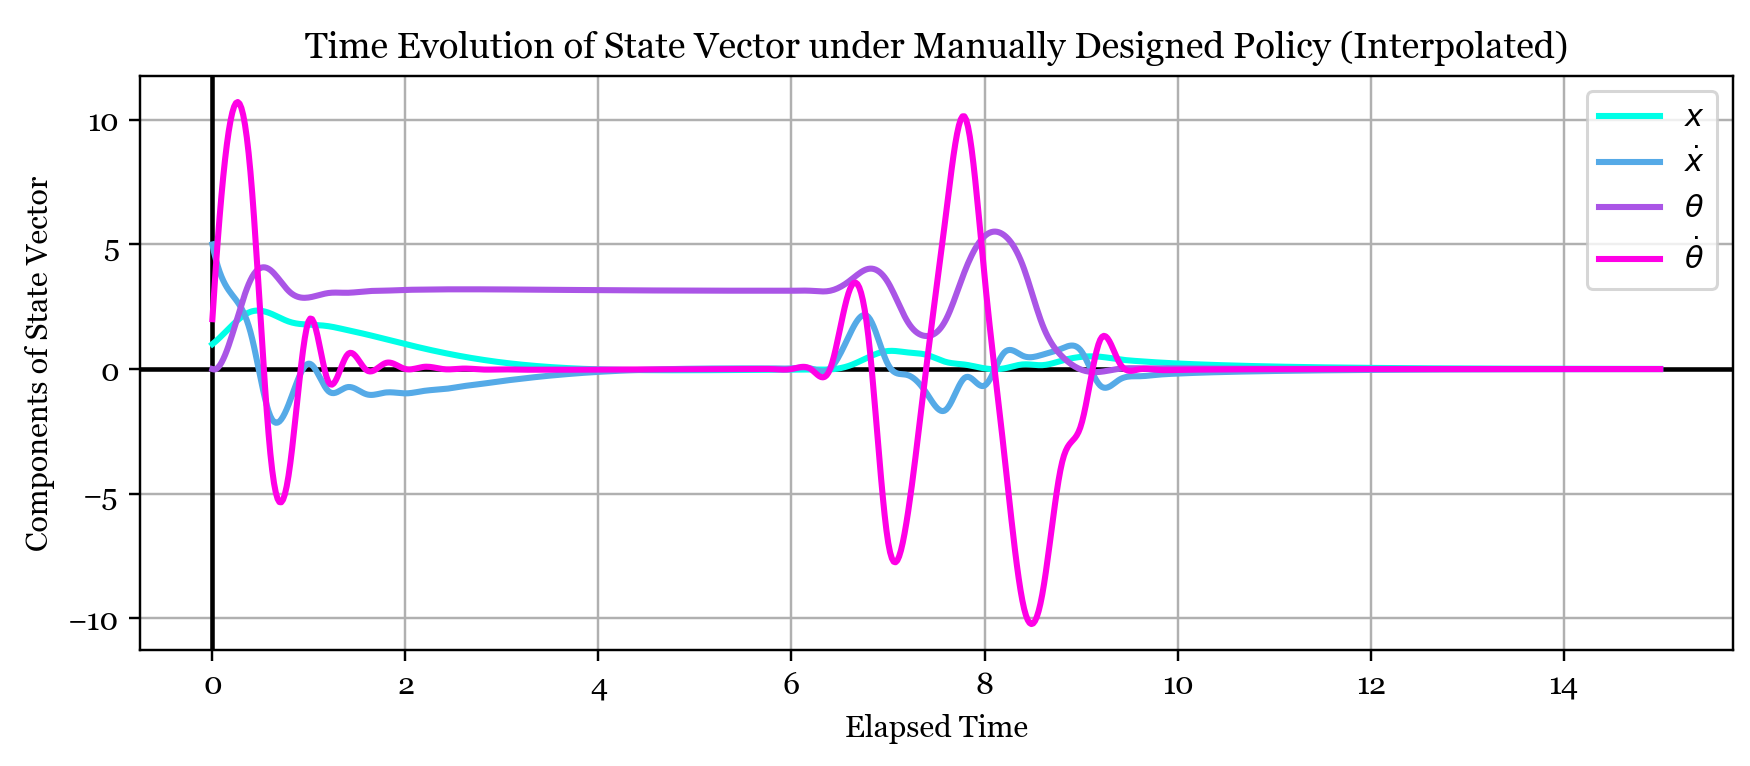

In [18]:
fig, ax = plt.subplots(1, 1, num=33, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.08, right=0.99)
sf3utility.setup_phase_portrait( ax )

state = np.array( [ 1., 5, 0, 2, 0 ] ) # initial state
p = np.array([-1, -1.5, 0, -1, 0]) # steady at middle

states = []
times = []
t = 0

for i in range(32):
    
    states.append(state)
    times.append(t)

    state[4] = p @ state
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()
    t += 0.2

forces = [5, 5, -5, -5, -5, -5, 4, 4, 4, 4, -2, -2]

for i, force in enumerate(forces):
    
    states.append(state)
    times.append(t)
    
    state[4] = force
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()
    t += 0.2
    
p = np.array( [0.75971638, 1.44284499, 17.05744679, 2.66183469, 0] ) # upright at middle

for i in range(32):
    
    states.append(state)
    times.append(t)

    state[4] = p @ state
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()
    t += 0.2
    
states = np.array( states )
times = np.array( times )

x = times
y = states

col_lerp = np.linspace(0, 1, 4)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255

labels = ["$x$","$\dot{x}$","$θ$","$\dot{θ}$"]

for i in range(4):
    
    f2 = scipy.interpolate.interp1d(x, y[:,i], kind='cubic')

    xnew = np.linspace(0, times[-1], 800)
    
    ax.plot( xnew, f2(xnew), color=colours[i], label=labels[i], linewidth=2 )

ax.set_title( "Time Evolution of State Vector under Manually Designed Policy (Interpolated)" )
ax.set_xlabel( "Elapsed Time" )
ax.set_ylabel( "Components of State Vector" )
ax.legend(loc="upper right")


Above is the time evolution of the state vector under my controller. The first set of ripples is the first linear policy bringing the cartpole from an arbitrary state to the equilibrium with the pole downwards, shown by the purple line (pole angle) being brought to rest at pi. The second set of ripples is the swing up and subsequent stabilisation in the upright configuration - after this all the states are zero as desired.

## Radial Basis Function Approach

It should also be possible to design a controller that uses radial basis functions to define the force in different regions of the state space. This force landscape would then be such that all points in the state space are guided toward the unstable equilibrium. For this problem I will use the initial condition where the cartpole is stationary at the origin, since I know a simple linear policy can bring the system to this state, or the system can be initialised in it, and it is likely that a real cartpole system would not be in an extremely erratic state to start with because of physical limitations and safety reasons.

The policy is now a sum over a few kernel functions, given by

$$
p(X) = \sum_i w_i e^{-0.5 (X-X_i)^T W (X-X_i)}
$$

I have decided to start with W as the identity matrix to reduce the number of parameters to worry about.

## Quadratic Controller???

<IPython.core.display.Javascript object>


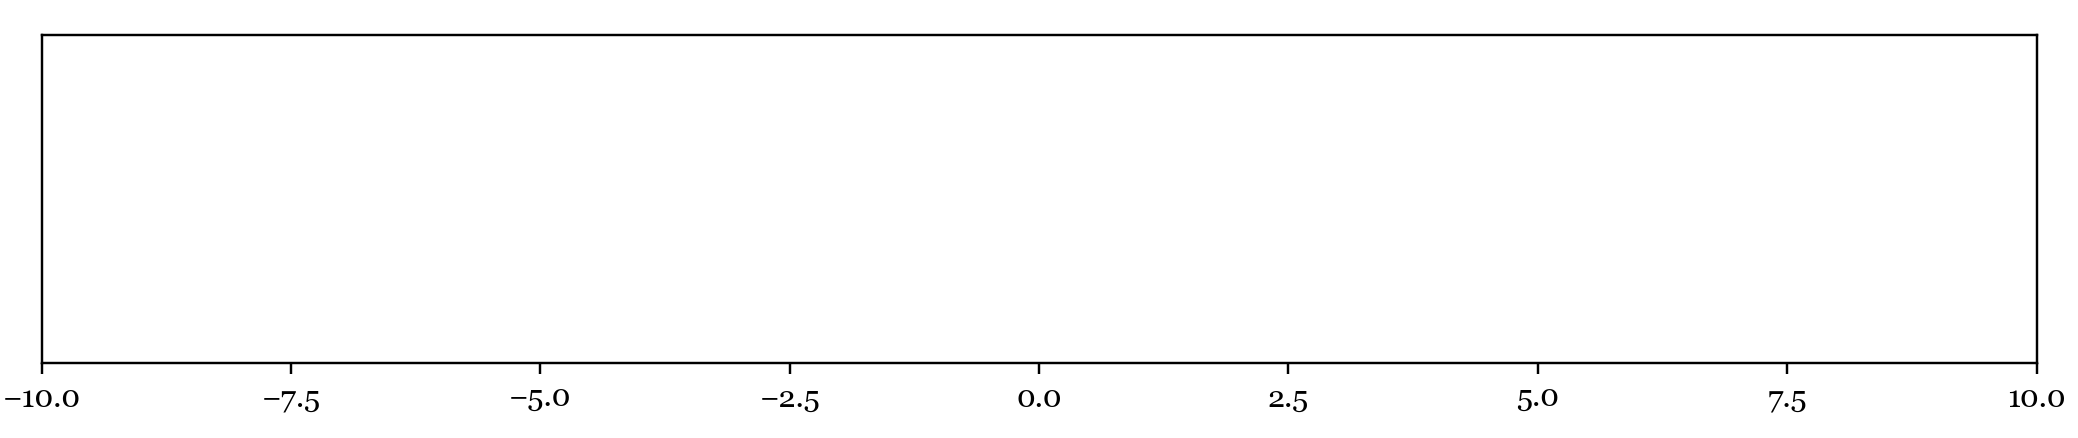

In [5]:
cart_pole_exp = CartPole.CartPole( visual=True, save_frames=False, fig_num=59 )

In [22]:
p = np.array(
 [ 0.79720335, -0.81892826, 0.16672051 , -0.09236256 ])
P = np.array(
[[-0.34134063, -0.44538288, -0.54157946,  0.5954045  ],
 [ 0.48675709, -1.13294381, -0.951934  , -0.56636443 ],
 [ 1.37535627, -1.66183934, -0.8258103 , -1.3074058  ],
 [ 2.1116826 ,  1.3782299 , -1.72001146,  0.1383763  ]])

In [23]:
state = np.array( [ 0, 0, np.pi, 0, 0 ] )
cart_pole_exp.set_state( state )
cart_pole_exp._render()

for i in range(12):

    # quadratic controller!!
    state[4] = p @ state[:4] + state[:4] @ P @ state[:4]
    
    state = CartPole.perform_action_RK4( state )
    cart_pole_exp.set_state( state[:4] )
    cart_pole_exp._render()
    
linear_p = np.array( [0.75971638, 1.44284499, 17.05744679, 2.66183469] )
    
for i in range(50):

    state[4] = linear_p @ state[:4]
    
    state = CartPole.perform_action_RK4( state )
    cart_pole_exp.set_state( state[:4] )
    cart_pole_exp._render()


In [8]:
p = np.array(
 [-0.39141334, -0.35567795,  0.44813621, -0.46802521]
)
P = np.array(
[[-0.05847553, -1.11992684, -0.44995409, -1.25715311],
 [-0.41638631,  0.10466255,  1.10751617,  1.18754805],
 [ 0.69309034, -0.51847106, -0.04314128, -0.8760343 ],
 [-0.74069395,  1.78405652, -0.94659632, -0.45347616]]
)

state = np.array( [ 0, 0, np.pi, 0, 0 ] )
cart_pole_exp.set_state( state )
cart_pole_exp._render()

for i in range(50):

    # quadratic controller!!
    state[4] = p @ state[:4] + state[:4] @ P @ state[:4]
    
    state = CartPole.perform_action_RK4( state )
    cart_pole_exp.set_state( state[:4] )
    cart_pole_exp._render()

<IPython.core.display.Javascript object>


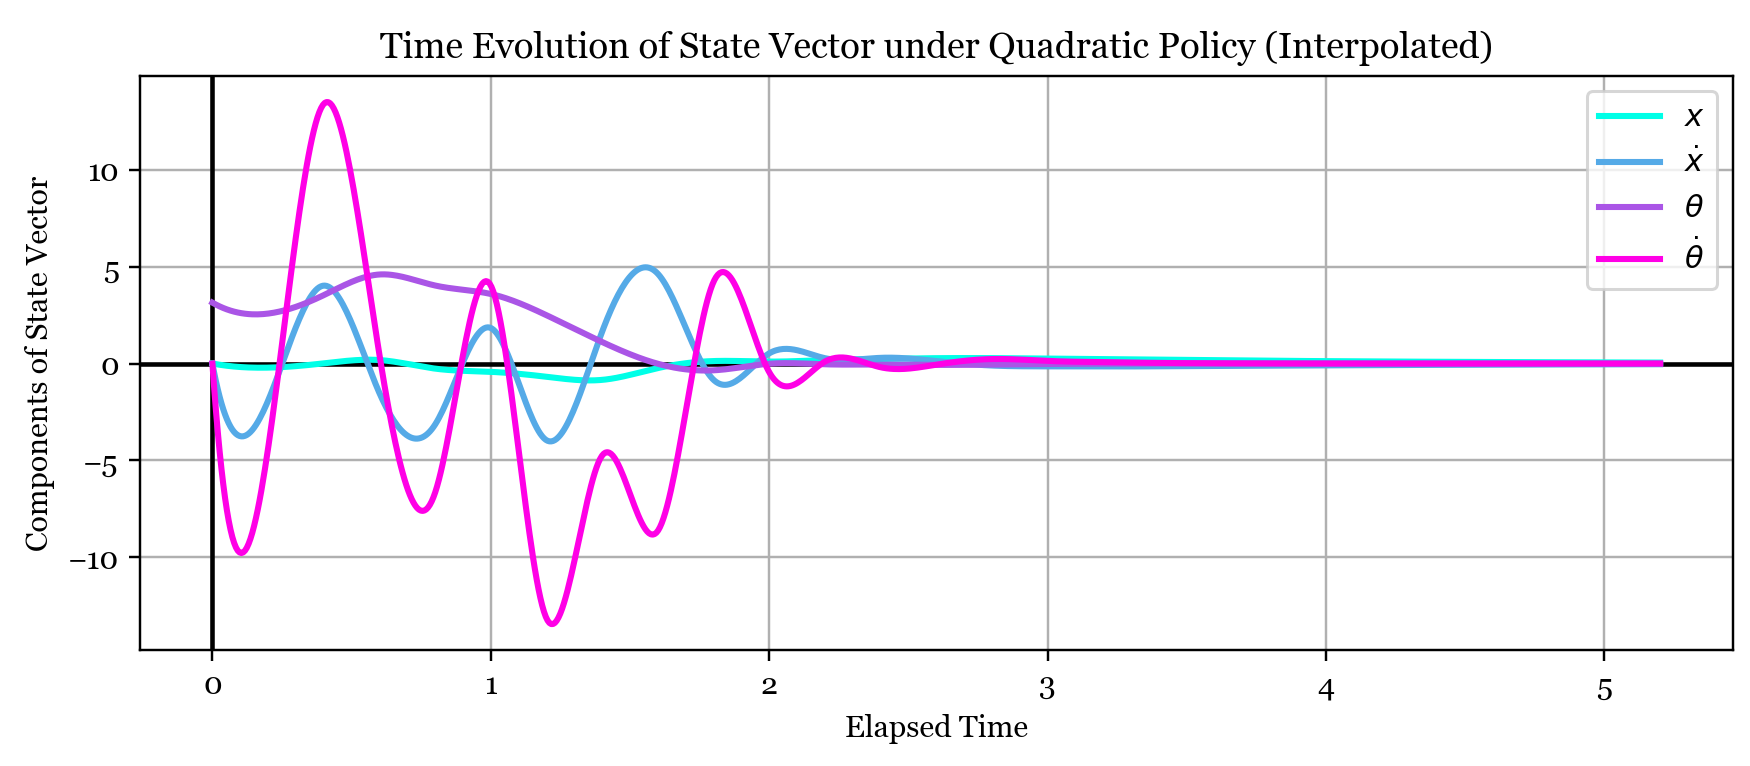

In [24]:
fig, ax = plt.subplots(1, 1, num=3, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.08, right=0.99)
sf3utility.setup_phase_portrait( ax )

state = np.array( [ 0, 0, np.pi, 0, 0 ] )

states = []
times = []
t = 0

for i in range(12):
    
    states.append(state)
    times.append(t)
    t += 0.2

    state[4] = p @ state[:4] + state[:4] @ P @ state[:4]
    state = CartPole.perform_action_RK4( state )
    
linear_p = np.array( [0.75971638, 1.44284499, 17.05744679, 2.66183469] )
    
for i in range(15):
    
    states.append(state)
    times.append(t)
    t += 0.2

    state[4] = linear_p @ state[:4]
    state = CartPole.perform_action_RK4( state )


states = np.array( states )
times = np.array( times )

x = times
y = states

col_lerp = np.linspace(0, 1, 4)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255

labels = ["$x$","$\dot{x}$","$θ$","$\dot{θ}$"]

for i in range(4):
    
    f2 = scipy.interpolate.interp1d(x, y[:,i], kind='cubic')

    xnew = np.linspace(0, times[-1], 800)
    
    ax.plot( xnew, f2(xnew), color=colours[i], label=labels[i], linewidth=2 )

ax.set_title( "Time Evolution of State Vector under Quadratic Policy (Interpolated)" )
ax.set_xlabel( "Elapsed Time" )
ax.set_ylabel( "Components of State Vector" )
ax.legend(loc="upper right")


## Quadratic Policy

So far I used a linear policy of the form p . X. It then became clear that the linear policy could not handle the nonlinearities of the cartpole system. So my next logical step was to try a quadratic controller, of the form p . X + X^T P X, hoping that it could capture some of the nonlinearity of the cartpole and enable swing-up. I could not think of a good way to find the optimal p vector and P matrix, so I just randomly selected them with entries normally distributed around 0 and kept doing random selections until I found a good setting. That setting is 

p = 
[ 0.79720335, -0.81892826, 0.16672051 , -0.09236256 ] 

P = 
[[-0.34134063, -0.44538288, -0.54157946,  0.5954045  ]
 [ 0.48675709, -1.13294381, -0.951934  , -0.56636443 ]
 [ 1.37535627, -1.66183934, -0.8258103 , -1.3074058  ]
 [ 2.1116826 ,  1.3782299 , -1.72001146,  0.1383763  ]]
 
and the swing-up sequence that this controller results in is plotted above. There is one subtlety which is that I could not find a good quadratic controller for the entire state space, so after 2.2 seconds of quadratic control (after which the cartpole is near the desired state) the controller reverts to a known working linear controller. One other thing is that this controller leverages large and erratic pole angular velocities which would probably be unrealistic in practice.

## Stability of Swing-up Controllers

I found that all the swing-up controllers I could come up with were extremely sensitive to noise. I think this is partly due to the sampling period of the controller being so long - even a slight deviation from what the controller expects builds up over the 0.2 seconds before the next force input and becomes unrecoverable. This is especially true for the quadratic controller - the weights in the p and P matrices are specific to the exact states that the system passes through during the swing-up, so any deviation is disaterous. I think for a more noise-resistant swing-up controller, it really is neccesary to use a finer timestep.

In [10]:
def quadratic_swingup_loss( p, P ):
    
    state = np.array( [0, 0, np.pi, 0, 0] )
    sim_steps = 12
    
    for i in range( sim_steps ):
        
        state[4] = p @ state[:4] + state[:4] @ P @ state[:4]
        state = CartPole.perform_action_RK4( state )
    
    return CartPole.loss( state[:4] )

In [11]:
def quadratic_swingup_loss( p, P ):
    
    state = np.array( [0, 0, np.pi, 0, 0] )
    loss = 0
    
    for i in range( 10 ):
        
        state[4] = p @ state[:4] + state[:4] @ P @ state[:4]
        state = CartPole.perform_action_RK4( state )
    
    for i in range( 10 ):
        
        state[4] = p @ state[:4] + state[:4] @ P @ state[:4]
        state = CartPole.perform_action_RK4( state )
        loss += CartPole.loss( state[:4] )
    
    return loss

""" best so far

p = 
 [-0.39141334 -0.35567795  0.44813621 -0.46802521]
P = 
 [[-0.05847553 -1.11992684 -0.44995409 -1.25715311]
 [-0.41638631  0.10466255  1.10751617  1.18754805]
 [ 0.69309034 -0.51847106 -0.04314128 -0.8760343 ]
 [-0.74069395  1.78405652 -0.94659632 -0.45347616]]
loss = 5.685331822985375
loss = 9.503086460035675 """

' best so far\n\np = \n [-0.39141334 -0.35567795  0.44813621 -0.46802521]\nP = \n [[-0.05847553 -1.11992684 -0.44995409 -1.25715311]\n [-0.41638631  0.10466255  1.10751617  1.18754805]\n [ 0.69309034 -0.51847106 -0.04314128 -0.8760343 ]\n [-0.74069395  1.78405652 -0.94659632 -0.45347616]]\nloss = 5.685331822985375\nloss = 9.503086460035675 '

In [12]:
def linear_swingup_loss( p ):
    
    state = np.array( [0, 0, np.pi, 0, 0] )
    sim_steps = 12
    
    for i in range( sim_steps ):
        
        state[4] = p @ state[:4]
        state = CartPole.perform_action_RK4( state )
    
    return CartPole.loss( state[:4] )

In [13]:
# best_p = None
# best_P = None
# best_loss = 99999

# for i in np.arange(1e+9):
    
#     p = np.random.randn( 4 )
#     P = np.random.randn( 4, 4 )
    
#     loss = quadratic_swingup_loss( p, P )
    
#     if loss < best_loss:
        
#         best_p = p
#         best_P = P
#         best_loss = loss
        
#         print("p = \n", p)
#         print("P = \n", P)
#         print("loss =", loss, "\n")

In [14]:
# best_p = None
# best_loss = 1

# for i in np.arange(1e+9):
    
#     p = np.random.randn( 4 )
    
#     loss = linear_swingup_loss( p )
    
#     if loss < best_loss:
        
#         best_p = p
#         best_loss = loss
        
#         print("p = \n", p)
#         print("loss =", loss, "\n")

<IPython.core.display.Javascript object>


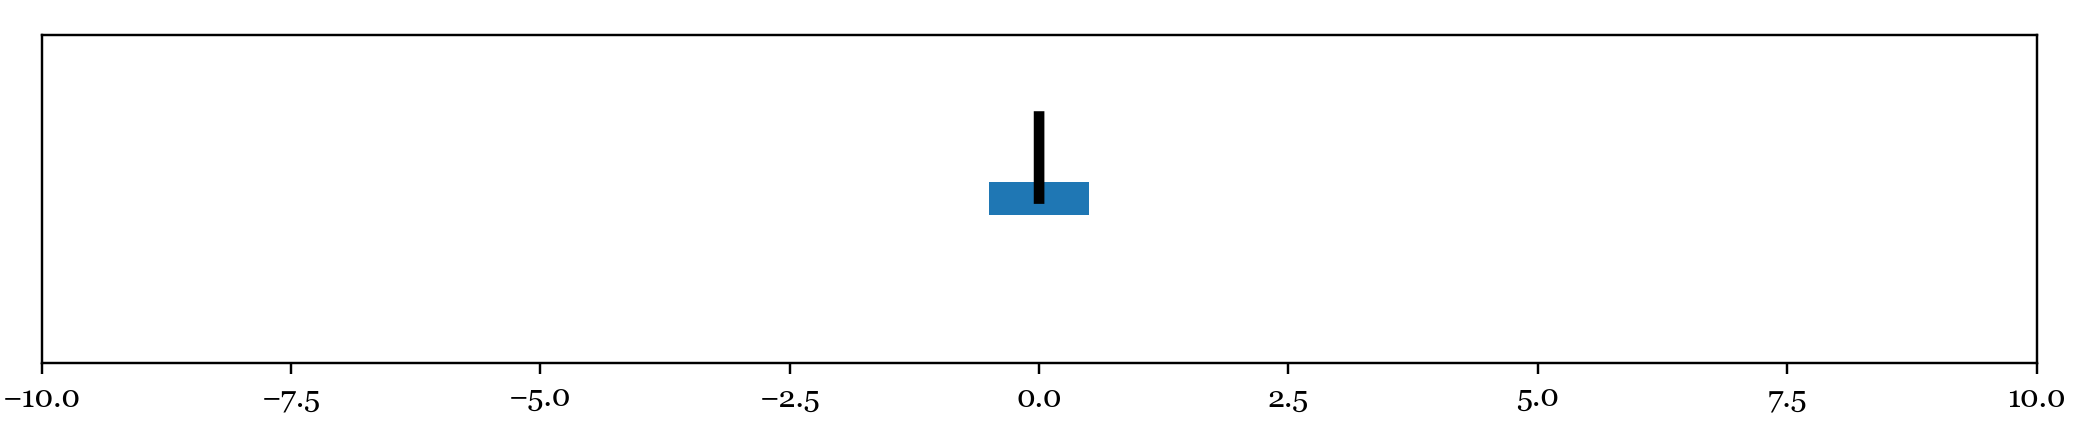

In [15]:
cart_pole_exp = CartPole.CartPole( visual=True, save_frames=False, fig_num=60 )

In [16]:
state = np.array( [ 0.5, 0.2, np.pi, 0.01, 0 ] )
cart_pole_exp.set_state( state )
cart_pole_exp._render()

m = cart_pole.pole_mass
l = cart_pole.pole_length
I = 1/3 * m * l**2

target_V = 1/2 * m * 9.8 * l

V = lambda state : 1/2 * I * state[3] ** 2 + 1/2 * m * 9.8 * l * np.cos(state[2])
remap = lambda theta : theta % (2*np.pi) - np.pi

for i in range(64):

    if V(state) < 1.2 and abs(state[2]) > 2:
        state[4] = -3.9 * remap(state[2])
    else:
        state[4] = 0
    
    state = CartPole.perform_action_RK4( state )
    cart_pole_exp.set_state( state[:4] )
    cart_pole_exp._render()
    
linear_p = np.array( [0.75971638, 1.44284499, 17.05744679, 2.66183469] )
    
for i in range(20):
    
    clipped_state = state[:]
    clipped_state[2] = CartPole.remap_angle(clipped_state[2])
    clipped_state[0] = np.clip(clipped_state[0], -0.5, 0.5)

    state[4] = linear_p @ state[:4]
    
    state = CartPole.perform_action_RK4( state )
    cart_pole_exp.set_state( state[:4] )
    cart_pole_exp._render()


<IPython.core.display.Javascript object>


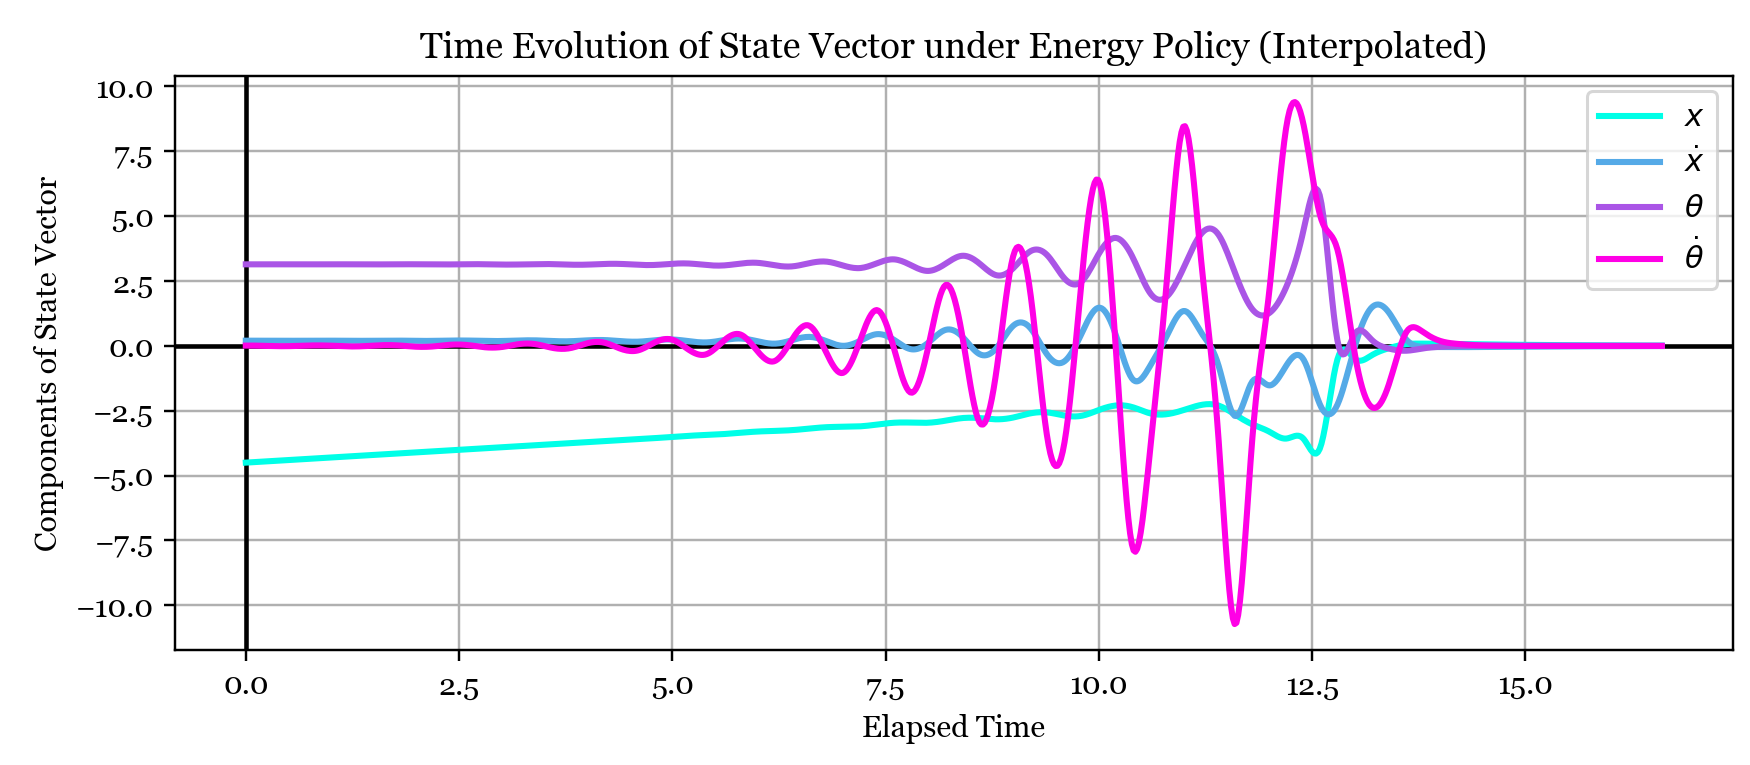

In [17]:
fig, ax = plt.subplots(1, 1, num=34, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.1, right=0.99)
sf3utility.setup_phase_portrait( ax )

states = []
times = []
t = 0

state = np.array( [ -4.5, 0.2, np.pi, 0.01, 0 ] )

m = cart_pole.pole_mass
l = cart_pole.pole_length
I = 1/3 * m * l**2

target_V = 1/2 * m * 9.8 * l

V = lambda state : 1/2 * I * state[3] ** 2 + 1/2 * m * 9.8 * l * np.cos(state[2])
remap = lambda theta : theta % (2*np.pi) - np.pi

for i in range(64):
    
    states.append(state)
    times.append(t)
    t += 0.2

    if V(state) < 1.2 and abs(state[2]) > 2:
        state[4] = -3.9 * remap(state[2])
    else:
        state[4] = 0
    
    state = CartPole.perform_action_RK4( state )
    
linear_p = np.array( [0.75971638, 1.44284499, 17.05744679, 2.66183469] )
    
for i in range(20):
    
    states.append(state)
    times.append(t)
    t += 0.2
    
    clipped_state = state[:]
    clipped_state[2] = CartPole.remap_angle(clipped_state[2])
    clipped_state[0] = np.clip(clipped_state[0], -0.5, 0.5)

    state[4] = linear_p @ state[:4]
    
    state = CartPole.perform_action_RK4( state )

states = np.array( states )
times = np.array( times )

x = times
y = states

col_lerp = np.linspace(0, 1, 4)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255

labels = ["$x$","$\dot{x}$","$θ$","$\dot{θ}$"]

for i in range(4):
    
    f2 = scipy.interpolate.interp1d(x, y[:,i], kind='cubic')

    xnew = np.linspace(0, times[-1], 800)
    
    ax.plot( xnew, f2(xnew), color=colours[i], label=labels[i], linewidth=2 )

ax.set_title( "Time Evolution of State Vector under Energy Policy (Interpolated)" )
ax.set_xlabel( "Elapsed Time" )
ax.set_ylabel( "Components of State Vector" )
ax.legend(loc="upper right")
    

## Energy-Based Policy

Another type of swing-up controller I read about is an energy-based controller, where the force input is modulated to increase the energy of the swinging pole until it has just enough to reach the top, at which point a linear controller is employed. In my case I set the force to be proportional to the negative pole angle, remapped to be zero at the bottom. This way of setting the force ensured that the system was excited at its natural frequency. The controller keeps the force at this level until the system energy is high enough, at which point it sets the force input to zero and lets the pole swing up. The linear controller from task 2.3 is then used to maintain balance in the upright position. This controller can also handle some nonzero initial cart position and velocity.